<a href="https://colab.research.google.com/github/Gabriel-git24/Cacao_disease_classification/blob/main/experimentwithotherimages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
if False:
  import splitfolders

  splitfolders.ratio(
      "/content/drive/MyDrive/Data_Science_Project_fall2024/Data Science Project/reorganized",
      output = "/content/drive/MyDrive/Data_Science_Project_fall2024/Data Science Project/reorganized_split",
      seed = 42,
      ratio = (.7, .15, .15),
  )
  pass

Copying files: 4390 files [04:32, 16.10 files/s]


In [ ]:
import matplotlib.pyplot as plt
# import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import wandb
from wandb.integration.keras import WandbCallback

In [ ]:
config = {
    "learning_rate": 0.001,
    "batch_size": 32,
    "epochs": 50,
    "architecture": "MobileNetV2",
    "dropout": 0.5,
    "image_size": (224, 224),


    #data_augumentation
    "rotation_range": 20,
    "width_shift_range": 0.15,
    "height_shift_range": 0.15,
    "shear_range": 0.15,
    "zoom_range": 0.2,
    "horizontal_flip": True,
    "brightness_range": [0.8, 1.2],
    "fill_mode": "nearest",

    #other_important info
    "optimizer": "Adam",
    "loss":"binary_crossentropy",
    "metrics": ["accuracy"],
    "regularizer": l2(0.001),
    "early_stopping_patience": 10
}


wandb.init(
    project="cacao_binary_classification",
    config=config
)

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: gabriel-osei (gabriel-osei-tarleton-state-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
split_dir = "/content/drive/MyDrive/Data_Science_Project_fall2024/Data Science Project/reorganized_split"
checkpoint_path = "/content/drive/MyDrive/DS2_nov 4/checkpoint/best_model.keras"

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=config["rotation_range"],
    height_shift_range=config["height_shift_range"],
    width_shift_range=config["width_shift_range"],
    shear_range=config["shear_range"],
    zoom_range=config["zoom_range"],
    horizontal_flip=config["horizontal_flip"],
    brightness_range=config["brightness_range"],
    fill_mode=config["fill_mode"]
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    split_dir + "/train",
    target_size=config["image_size"],
    batch_size=config["batch_size"],
    class_mode="binary",
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    split_dir + "/val",
    target_size=config["image_size"],
    batch_size=config["batch_size"],
    class_mode="binary",
    shuffle=False
)

test_generator = val_datagen.flow_from_directory(
    split_dir + "/test",
    target_size=config["image_size"],
    batch_size=config["batch_size"],
    class_mode="binary",
    shuffle=False
)

Found 3072 images belonging to 2 classes.
Found 657 images belonging to 2 classes.
Found 661 images belonging to 2 classes.


In [ ]:

base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=config["image_size"] + (3,)
)

base_model.trainable = False #freezing the layers to avoid data from retraining our model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(config["dropout"])(x)

outputs = Dense(
    1,
    activation="sigmoid",
    kernel_regularizer=config["regularizer"]
)(x)

final_model = Model(
    inputs=base_model.input,
    outputs=outputs
)

final_model.compile(
    optimizer=Adam(learning_rate=config["learning_rate"]),
    loss=config["loss"],
    metrics=config["metrics"]
)

# Making sure model saves at checkpoints

model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=False,
    mode="max",
    verbose=1
)

early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=config["early_stopping_patience"],
    restore_best_weights=True,
    mode="max"
)

final_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
import time
start_time = time.time()

history = final_model.fit(
    train_generator,
    epochs = config["epochs"],
    validation_data = validation_generator,
    callbacks = [model_checkpoint, early_stopping,
                 wandb.keras.WandbMetricsLogger(),
                 wandb.keras.WandbModelCheckpoint(filepath=checkpoint_path,
                                                  monitor="val_accuracy",
                                                  save_best_only=True,
                                                  save_weights_only=False,
                                                  mode="max")]
)

wandb.finish()

end_time = time.time()

elapsed_time_seconds = end_time - start_time

print(f"Training completed in {elapsed_time_seconds:.2f} seconds.")

wandb: WARNING When using `save_best_only`, ensure that the `filepath` argument contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. This ensures correct interpretation of the logged artifacts.
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7199 - loss: 0.6277
Epoch 1: val_accuracy improved from -inf to 0.85845, saving model to /content/drive/MyDrive/DS2_nov 4/checkpoint/best_model.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.7204 - loss: 0.6267 - val_accuracy: 0.8584 - val_loss: 0.3536
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8394 - loss: 0.3875
Epoch 2: val_accuracy improved from 0.85845 to 0.86758, saving model to /content/drive/MyDrive/DS2_nov 4/checkpoint/best_model.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.8394 - loss: 0.3875 - val_accuracy: 0.8676 - val_loss: 0.3166
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8474 - loss: 0.3670
Epoch 3: val_accuracy improved from 0.86758 to 0.87976, saving model to /content/drive/MyDrive/DS2_nov 4/checkpoint/best_model.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.8474 - loss: 0.3669 - val_accuracy: 0.8798 - val_loss: 0.3076
Epoch 4

epoch/accuracy,▁▅▆▆▆▇▇▇▇▇▇▇█▇███▇▇█▇▇▇▇█▇██▇█
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▂▄▆▅▆▆▆▆▇▇▇█▆▆▆▆███▇█▇▆▇▇▇██▇
epoch/val_loss,█▅▄▃▄▃▂▂▂▁▂▂▁▂▂▂▂▁▁▁▁▂▁▃▁▁▂▁▁▂
epoch/accuracy,0.89583
epoch/epoch,29
epoch/learning_rate,0.001
epoch/loss,0.27573
epoch/val_accuracy,0.89802


Training completed in 4760.06 seconds.


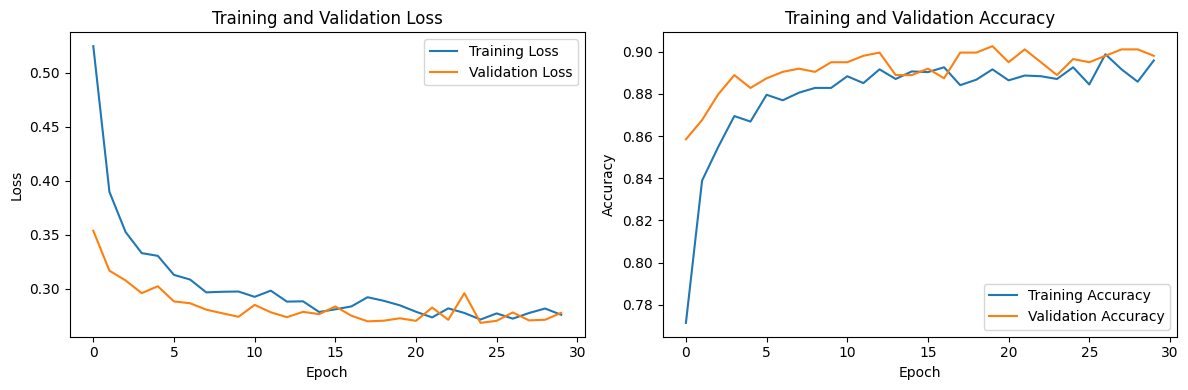

In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()